<h1  align='center'>Sepsis Next Activity and Remaining Time Prediction Model</h1>

<h1  align='center'>Data Cleaning & Feature Selection</h1>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import shap
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

C:\Users\hskma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2> Data Load: Loading Sepsis Event Log into a dataframe</h2>

In [2]:
# Load the data
df_org = pd.read_csv("Sepsis_Cases_Log.csv")


In [3]:
df_org.head()

,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,15:41.0,Variant 61,61,complete,A,True,True,True,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,Leucocytes,27:00.0,Variant 61,61,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,CRP,27:00.0,Variant 61,61,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,LacticAcid,27:00.0,Variant 61,61,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,ER Triage,33:37.0,Variant 61,61,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_org.columns

Index(['Case ID', 'Activity', 'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'org:group', 'InfectionSuspected',
       'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie',
       'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor',
       'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax',
       'SIRSCritTemperature', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
       'Oligurie', 'DiagnosticLacticAcid', 'Diagnose', 'Hypoxie',
       'DiagnosticUrinarySediment', 'DiagnosticECG', 'Leucocytes', 'CRP',
       'LacticAcid'],
      dtype='object')

# Droping features that are not required to build our model

In [5]:
df = df_org.drop(columns=['org:group', 'Variant', 'Variant index', 'Diagnose', 'lifecycle:transition'])
df.head()


,Case ID,Activity,Complete Timestamp,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,15:41.0,True,True,True,True,True,True,True,...,True,False,False,True,False,True,True,NaN,NaN,NaN
1,A,Leucocytes,27:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,CRP,27:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,LacticAcid,27:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,ER Triage,33:37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# unique activities
unique_activities = df['Activity'].unique()
unique_activities

array(['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage',
       'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC',
       'Release A', 'Return ER', 'Admission IC', 'Release B', 'Release C',
       'Release D', 'Release E'], dtype=object)

# Creating Activity Flow Dataframe

In [7]:

df_act_flow = pd.DataFrame()

# Loop through each unique Case ID
for case in df['Case ID'].unique():
    # Filter the merged_df for the current Case ID
    case_merged_df = df[df['Case ID'] == case]
    
    # Extract the activities as a list
    activity_flow = case_merged_df['Activity'].tolist()
    
    # Add the Case ID as the first column and the activities as subsequent columns
    row_merged_df = [case] + activity_flow
    
    # Append the row to the final DataFrame
    df_act_flow = pd.concat([df_act_flow, pd.DataFrame([row_merged_df])], ignore_index=True)

# Rename columns: first column as 'Case ID', remaining columns as 'Activity 1', 'Activity 2', etc.
columns = ['Case ID'] + [f'Activity {i+1}' for i in range(df_act_flow.shape[1] - 1)]
df_act_flow.columns = columns

# Inspect the resulting DataFrame
print(df_act_flow.head(10))



  Case ID       Activity 1  Activity 2        Activity 3      Activity 4  \
0       A  ER Registration  Leucocytes               CRP      LacticAcid   
1       B  ER Registration   ER Triage               CRP      LacticAcid   
2       C  ER Registration   ER Triage  ER Sepsis Triage      Leucocytes   
3       D  ER Registration   ER Triage  ER Sepsis Triage             CRP   
4       E  ER Registration   ER Triage  ER Sepsis Triage       IV Liquid   
5       F  ER Registration   ER Triage  ER Sepsis Triage      Leucocytes   
6       G  ER Registration   ER Triage  ER Sepsis Triage       IV Liquid   
7       H  ER Registration   ER Triage  ER Sepsis Triage             CRP   
8       I  ER Registration   ER Triage  ER Sepsis Triage  IV Antibiotics   
9       J  ER Registration   ER Triage  ER Sepsis Triage             CRP   

       Activity 5        Activity 6      Activity 7      Activity 8  \
0       ER Triage  ER Sepsis Triage       IV Liquid  IV Antibiotics   
1      Leucocytes  ER

# Filtering out those who Does not start with ER Registraion

In [8]:
# Ensure the first activity column exists before filtering
if df_act_flow.shape[1] > 1:  # Checking if there is at least one activity column
    df_act_flow = df_act_flow[df_act_flow['Activity 1'] == "ER Registration"].reset_index(drop=True)

# Inspect the filtered DataFrame
print(df_act_flow.head(10))


  Case ID       Activity 1  Activity 2        Activity 3      Activity 4  \
0       A  ER Registration  Leucocytes               CRP      LacticAcid   
1       B  ER Registration   ER Triage               CRP      LacticAcid   
2       C  ER Registration   ER Triage  ER Sepsis Triage      Leucocytes   
3       D  ER Registration   ER Triage  ER Sepsis Triage             CRP   
4       E  ER Registration   ER Triage  ER Sepsis Triage       IV Liquid   
5       F  ER Registration   ER Triage  ER Sepsis Triage      Leucocytes   
6       G  ER Registration   ER Triage  ER Sepsis Triage       IV Liquid   
7       H  ER Registration   ER Triage  ER Sepsis Triage             CRP   
8       I  ER Registration   ER Triage  ER Sepsis Triage  IV Antibiotics   
9       J  ER Registration   ER Triage  ER Sepsis Triage             CRP   

       Activity 5        Activity 6      Activity 7      Activity 8  \
0       ER Triage  ER Sepsis Triage       IV Liquid  IV Antibiotics   
1      Leucocytes  ER

# Checking for the number of cases still left

In [9]:
df_act_flow.shape

(957, 186)

# Plotting a Scatter plot for the number of activities

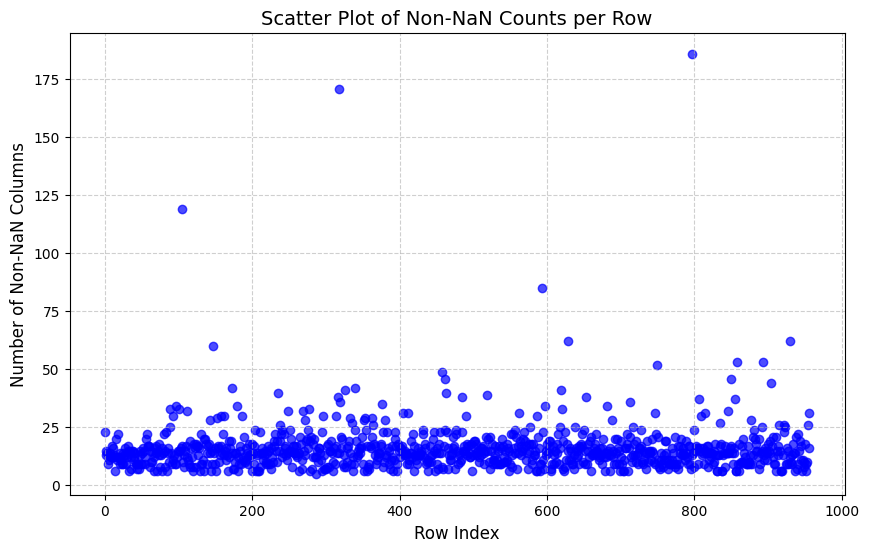

In [10]:
# Step 1: Count the number of non-NaN values for each row
df_act_flow['Non-NaN Count'] = df_act_flow.notnull().sum(axis=1)

# Step 2: Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_act_flow.index, df_act_flow['Non-NaN Count'], alpha=0.7, color='blue')
plt.title('Scatter Plot of Non-NaN Counts per Row', fontsize=14)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('Number of Non-NaN Columns', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Filtering out those rare cases
As we can observe there are very few cases (10 in count ) having more than 50 activites. So dropping them for better model training.

In [11]:
df_act_flow['Non-NaN Count'] = df_act_flow.notnull().sum(axis=1)

df_act_flow_filtered = df_act_flow[(df_act_flow['Non-NaN Count'] >= 4) & (df_act_flow['Non-NaN Count'] <= 50)]

df_act_flow_filtered = df_act_flow_filtered.drop(columns=['Non-NaN Count'])

df_act_flow_filtered.head()


,Case ID,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,...,Activity 176,Activity 177,Activity 178,Activity 179,Activity 180,Activity 181,Activity 182,Activity 183,Activity 184,Activity 185
0,A,ER Registration,Leucocytes,CRP,LacticAcid,ER Triage,ER Sepsis Triage,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B,ER Registration,ER Triage,CRP,LacticAcid,Leucocytes,ER Sepsis Triage,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,ER Registration,ER Triage,ER Sepsis Triage,Leucocytes,CRP,IV Liquid,IV Antibiotics,Admission NC,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D,ER Registration,ER Triage,ER Sepsis Triage,CRP,LacticAcid,Leucocytes,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E,ER Registration,ER Triage,ER Sepsis Triage,IV Liquid,CRP,Leucocytes,LacticAcid,IV Antibiotics,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_act_flow_filtered.shape

(947, 186)

# Cutting short the unnecessary columns

In [13]:
df_act_flow_filtered = df_act_flow_filtered.iloc[:, :50]

# Display the updated DataFrame
df_act_flow_filtered.head()


,Case ID,Activity 1,Activity 2,Activity 3,Activity 4,Activity 5,Activity 6,Activity 7,Activity 8,Activity 9,...,Activity 40,Activity 41,Activity 42,Activity 43,Activity 44,Activity 45,Activity 46,Activity 47,Activity 48,Activity 49
0,A,ER Registration,Leucocytes,CRP,LacticAcid,ER Triage,ER Sepsis Triage,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B,ER Registration,ER Triage,CRP,LacticAcid,Leucocytes,ER Sepsis Triage,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,ER Registration,ER Triage,ER Sepsis Triage,Leucocytes,CRP,IV Liquid,IV Antibiotics,Admission NC,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D,ER Registration,ER Triage,ER Sepsis Triage,CRP,LacticAcid,Leucocytes,IV Liquid,IV Antibiotics,Admission NC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E,ER Registration,ER Triage,ER Sepsis Triage,IV Liquid,CRP,Leucocytes,LacticAcid,IV Antibiotics,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Resulting Scatter Plot


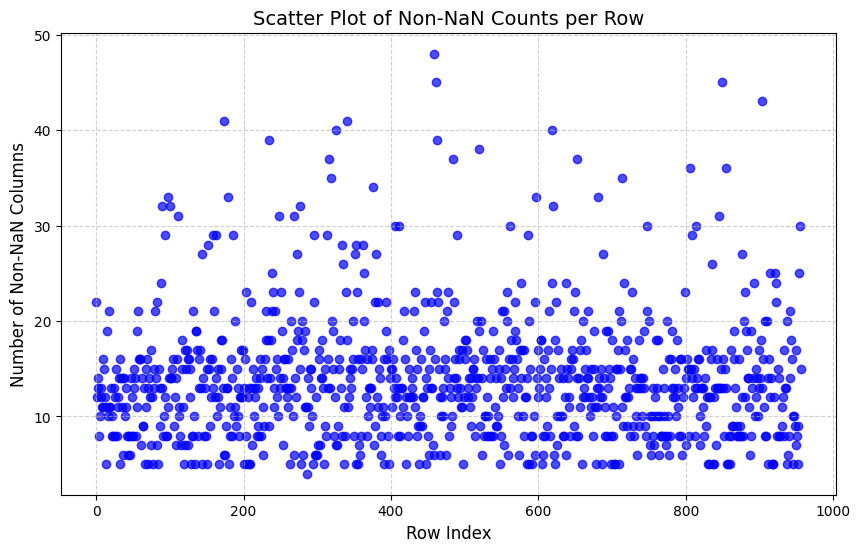

In [14]:
df_act_flow_filtered['Non-NaN Count'] = df_act_flow_filtered.notnull().sum(axis=1) -1

plt.figure(figsize=(10, 6))
plt.scatter(df_act_flow_filtered.index, df_act_flow_filtered['Non-NaN Count'], alpha=0.7, color='blue')
plt.title('Scatter Plot of Non-NaN Counts per Row', fontsize=14)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('Number of Non-NaN Columns', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [15]:
filtered_case_ids = df_act_flow_filtered['Case ID'].unique()
df_act_flow_filtered = df_act_flow_filtered.drop(columns=['Non-NaN Count'])


# Now creating a dataframe Other attributes

As the values of the other attributes are wriiten in the row or ER Registration.

In [16]:
df_er_registration = df[df['Activity'] == 'ER Registration']


Now removing the filtered cases and then just keeping the Other attributes


In [17]:
# Remove rows with filtered Case IDs
df_er_registration = df_er_registration[df_er_registration['Case ID'].isin(filtered_case_ids)]

# Reset index for cleanliness 
df_er_registration = df_er_registration.reset_index(drop=True)

# Step 3: Process df_other_attributes
df_other_attributes = df_er_registration.drop(columns=['Activity', 'Leucocytes', 'CRP', 'LacticAcid', 'Complete Timestamp'])


In [18]:
# Export the DataFrames to CSV files
df_act_flow_filtered.to_csv('Sepsis_Activity_Flow.csv', index=False)
df_other_attributes.to_csv('Sepsis_Other_Attributes.csv', index=False)

# Creating a datframe for Biomarkers (Leucocytes, CRP, and LacticAcid)

In [19]:
# Filter relevant columns
columns_to_keep = ['Case ID', 'Activity', 'Leucocytes', 'CRP', 'LacticAcid']
df_filtered = df[columns_to_keep].copy()

# Reshape the DataFrame to have 'Case ID', 'Activity', 'Value', 'Next Activity'
df_melted = df_filtered.melt(id_vars=['Case ID', 'Activity'], 
                              value_vars=['Leucocytes', 'CRP', 'LacticAcid'], 
                              var_name='Biomarker', 
                              value_name='Value')

#  Create a new column for the next activity
df_melted['Next Activity'] = df_melted.groupby('Case ID')['Activity'].shift(-1)

#  Drop rows where Value or Next Activity is NaN
df_biomarkers_next_activity = df_melted.dropna().reset_index(drop=True)


In [20]:
# Define biomarker ranges
biomarker_ranges = {
    'Leucocytes': ([0, 7.5, 12.5, 15.0, 30.0, np.inf], ['Low', 'Normal', 'Elevated', 'High', 'Critical']),
    'CRP': ([0, 50, 100, 150, 250, np.inf], ['Low', 'Mild', 'Moderate', 'Severe', 'Critical']),
    'LacticAcid': ([0, 1.2, 1.8, 2.5, 4.0, np.inf], ['Normal', 'Borderline', 'Elevated', 'High', 'Critical'])
}

# Apply ranges to dataset
df_biomarkers_next_activity['Range'] = df_biomarkers_next_activity.apply(
    lambda row: pd.cut([row['Value']], 
                       bins=biomarker_ranges[row['Biomarker']][0],
                       labels=biomarker_ranges[row['Biomarker']][1])[0], axis=1)


In [21]:
# Save the resulting DataFrame to a CSV file
df_biomarkers_next_activity.to_csv('Sepsis_Biomarkers_Next_Activity.csv', index=False)

# Display the resulting DataFrame
df_biomarkers_next_activity.head()


,Case ID,Activity,Biomarker,Value,Next Activity,Range
0,A,Leucocytes,Leucocytes,9.6,CRP,Normal
1,A,Leucocytes,Leucocytes,8.7,Leucocytes,Normal
2,A,Leucocytes,Leucocytes,9.6,CRP,Normal
3,A,Leucocytes,Leucocytes,10.7,CRP,Normal
4,A,Leucocytes,Leucocytes,13.0,Leucocytes,Elevated


# Feature Selection using SHAP & Correlation Analysis

In [25]:
# Ensure SHAP runs on CPU to avoid GPU memory issues
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load dataset
file_path = "Sepsis_Other_Attributes.csv"  
df = pd.read_csv(file_path)

# Drop non-numeric identifier
df = df.drop(columns=['Case ID'])

# Define features and target
X = df.drop(columns=['InfectionSuspected'])
y = df['InfectionSuspected']


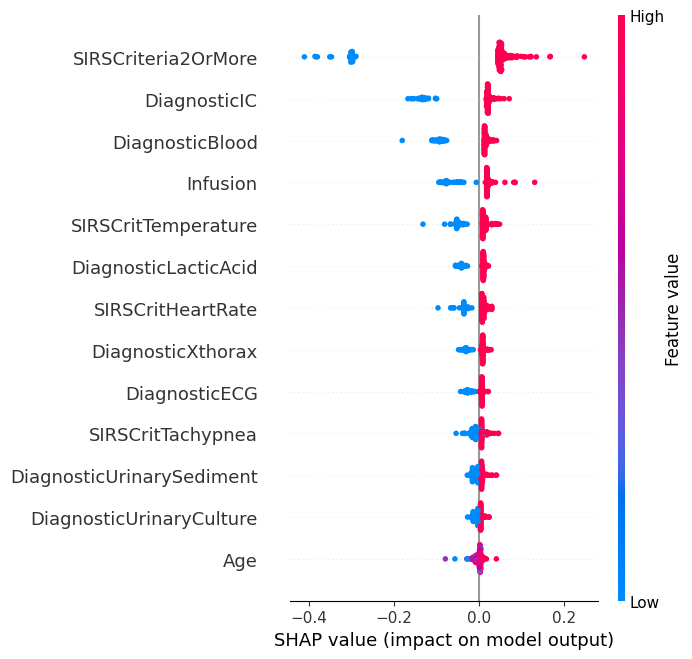

In [26]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Check if SHAP outputs multiple arrays
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Select SHAP values for the positive class

# Ensure dimensions match
shap_values = shap_values[:, :X_test.shape[1]]
# Select SHAP values for the positive class (class index 1)
shap_values_corrected = shap_values[:, :, 1]  # Keep only class 1 values

# Increase figure size
plt.figure(figsize=(18, 14))

# Generate SHAP summary plot
shap.summary_plot(shap_values_corrected, X_test, max_display=13, show=False)

# Adjust layout
plt.subplots_adjust(left=0.5)  # Increase left margin for labels

plt.show()


# Correlation Analysis on Features

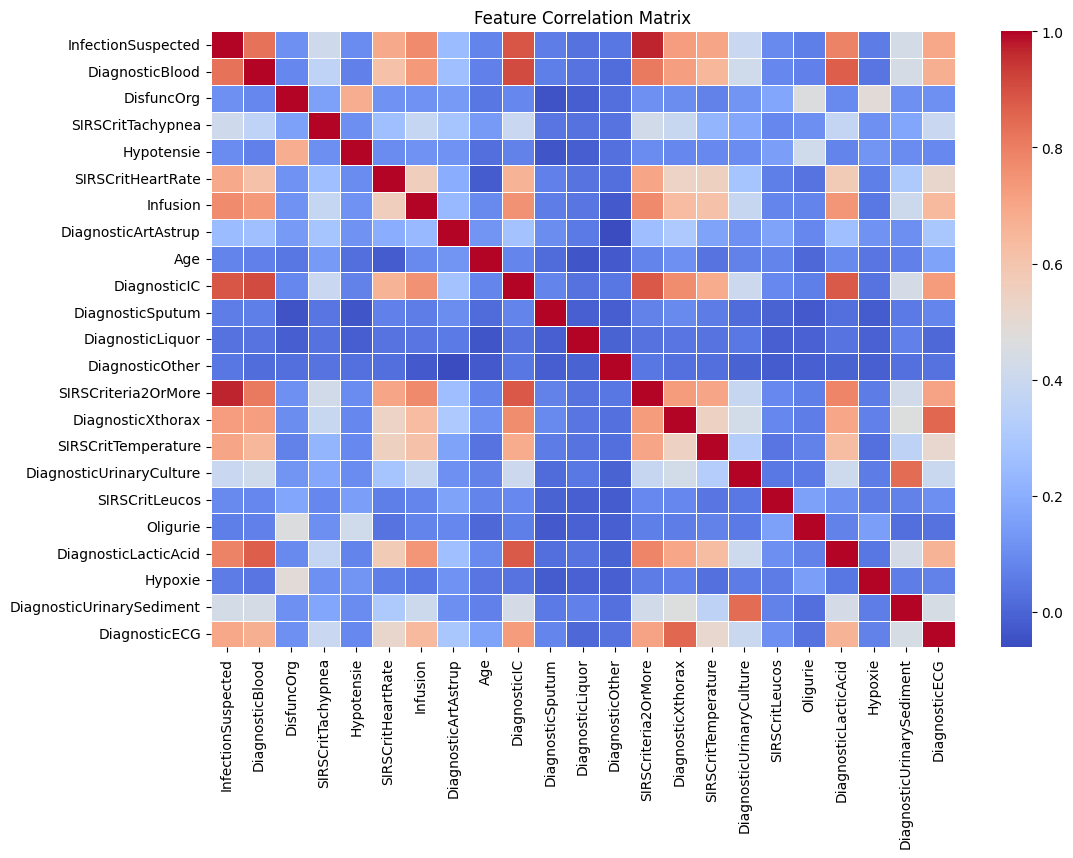

In [27]:
# Drop 'Case ID' as it's not useful for correlation analysis
df_corr = df_other_attributes.drop(columns=['Case ID'])

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [28]:

# Identify highly correlated features (threshold > 0.8)
high_corr_features = set()
threshold = 0.85
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[row, col]) > threshold:
            high_corr_features.add((row, col, corr_matrix.loc[row, col]))

# Convert to DataFrame for easier interpretation
df_high_corr = pd.DataFrame(high_corr_features, columns=['Feature 1', 'Feature 2', 'Correlation'])


In [29]:
# Display highly correlated features
print("Highly Correlated Features:")
print(df_high_corr)

Highly Correlated Features:
               Feature 1             Feature 2  Correlation
0    SIRSCriteria2OrMore    InfectionSuspected     0.969246
1           DiagnosticIC    InfectionSuspected     0.884910
2     InfectionSuspected          DiagnosticIC     0.884910
3          DiagnosticECG     DiagnosticXthorax     0.853909
4    SIRSCriteria2OrMore          DiagnosticIC     0.883180
5        DiagnosticBlood          DiagnosticIC     0.908060
6   DiagnosticLacticAcid          DiagnosticIC     0.877256
7   DiagnosticLacticAcid       DiagnosticBlood     0.869896
8     InfectionSuspected   SIRSCriteria2OrMore     0.969246
9      DiagnosticXthorax         DiagnosticECG     0.853909
10          DiagnosticIC  DiagnosticLacticAcid     0.877256
11          DiagnosticIC   SIRSCriteria2OrMore     0.883180
12          DiagnosticIC       DiagnosticBlood     0.908060
13       DiagnosticBlood  DiagnosticLacticAcid     0.869896


Filtering

In [30]:

# Features with high SHAP importance from the user's SHAP plot
shap_important_features = [
    "SIRSCriteria2OrMore", "DiagnosticIC", "DiagnosticBlood", "Infusion",
    "SIRSCritTemperature", "DiagnosticLacticAcid", "SIRSCritHeartRate",
    "DiagnosticXthorax", "DiagnosticECG", "SIRSCritTachypnea",
    "DiagnosticUrinarySediment", "DiagnosticUrinaryCulture", "Age"
]

# Remove highly correlated features (keeping the most relevant ones)
selected_features = shap_important_features.copy()

# Define a function to drop highly correlated features while keeping the most important ones
def remove_highly_correlated_features(feature_list, corr_matrix, threshold=0.8):
    to_remove = set()
    for i in range(len(feature_list)):
        for j in range(i + 1, len(feature_list)):
            if feature_list[i] in to_remove or feature_list[j] in to_remove:
                continue
            if abs(corr_matrix.loc[feature_list[i], feature_list[j]]) > threshold:
                # Keep the one appearing first in SHAP importance (higher priority)
                to_remove.add(feature_list[j])

    return [f for f in feature_list if f not in to_remove]

# Apply correlation-based filtering
selected_features = remove_highly_correlated_features(selected_features, corr_matrix)

# Add the target feature
selected_features.append("InfectionSuspected")

# Display the final selected features
selected_features_df = pd.DataFrame({"Selected Features": selected_features})


In [31]:
print("\nFinal Selected Features:")
print(selected_features_df)


Final Selected Features:
           Selected Features
0        SIRSCriteria2OrMore
1                   Infusion
2        SIRSCritTemperature
3       DiagnosticLacticAcid
4          SIRSCritHeartRate
5          DiagnosticXthorax
6          SIRSCritTachypnea
7  DiagnosticUrinarySediment
8                        Age
9         InfectionSuspected


- Identified the most relevant Features
- Justified Feature choices based on medical insights

# Filter the dataset to keep only the selected features


In [32]:
df_selected = df_other_attributes[selected_features]

df_selected.head()

,SIRSCriteria2OrMore,Infusion,SIRSCritTemperature,DiagnosticLacticAcid,SIRSCritHeartRate,DiagnosticXthorax,SIRSCritTachypnea,DiagnosticUrinarySediment,Age,InfectionSuspected
0,True,True,True,True,True,True,True,True,85.0,True
1,True,True,True,True,True,True,True,True,45.0,True
2,True,True,True,True,True,False,False,True,55.0,True
3,True,True,True,True,True,True,True,False,70.0,True
4,True,True,True,True,True,True,True,True,75.0,True


In [33]:
# Add 'Case ID' to the selected features
df_selected['Case ID'] = df_other_attributes['Case ID']

# Reorder columns to have 'Case ID' as the first column
df_selected = df_selected[['Case ID'] + selected_features]

# Display the updated DataFrame with 'Case ID' as the first column
df_selected.head()

C:\Users\hskma\AppData\Local\Temp\ipykernel_3872\1970785413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Case ID'] = df_other_attributes['Case ID']


,Case ID,SIRSCriteria2OrMore,Infusion,SIRSCritTemperature,DiagnosticLacticAcid,SIRSCritHeartRate,DiagnosticXthorax,SIRSCritTachypnea,DiagnosticUrinarySediment,Age,InfectionSuspected
0,A,True,True,True,True,True,True,True,True,85.0,True
1,B,True,True,True,True,True,True,True,True,45.0,True
2,C,True,True,True,True,True,False,False,True,55.0,True
3,D,True,True,True,True,True,True,True,False,70.0,True
4,E,True,True,True,True,True,True,True,True,75.0,True


In [34]:
# Save the selected features to a new CSV file
df_selected.to_csv('Sepsis_Selected_Features.csv', index=False)
